In [1]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer 
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel 
from pyspark.ml import Pipeline, PipelineModel 
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
spark = (SparkSession.builder
         .master('local')
         .appName('Demo full pipeline')
         .getOrCreate())

In [3]:
#--------------------------------------------------------------
# Dataset
#--------------------------------------------------------------
rawdata = spark.read.options(header='True', inferSchema='True').format("csv").load("FC-Churn.csv")

In [4]:
## printSchema
rawdata.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [5]:
rawdata.limit(5).toPandas() 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
rawdata.select(["customerID","Churn"]).show(5)

+----------+-----+
|customerID|Churn|
+----------+-----+
|7590-VHVEG|   No|
|5575-GNVDE|   No|
|3668-QPYBK|  Yes|
|7795-CFOCW|   No|
|9237-HQITU|  Yes|
+----------+-----+
only showing top 5 rows



In [7]:
#--------------------------------------------------------------
# Exploratory Data Analysis
#--------------------------------------------------------------

In [8]:
pd.set_option('display.max_columns', 500)

In [9]:
rawdata.describe().toPandas()

,summary,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,count,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052
1,mean,None,None,0.16222348269994327,None,None,33.88499716392513,None,None,None,None,None,None,None,None,None,None,None,None,65.16186188315376,2313.343161482747,None
2,stddev,None,None,0.36868184009892613,None,None,121.45820495696698,None,None,None,None,None,None,None,None,None,None,None,None,42.33977626784554,3205.57623018018,None
3,min,0000-AAAAA,Female,0,No,No,-1,No,No,DSL,No,No,NA,No,No,No,Month-to-month,No,Bank transfer (automatic),-34.6,,No
4,max,9999-IAZLT,NA,1,Yes,Yes,10000,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,year,Yes,Mailed check,2450.75,999.9,Yes


In [10]:
# The min for tenure is (-1)
# The min for Device protection (NA)
# The min for monthly payment (-34.6)
# min for totalcharges (empty value)

In [11]:
rawdata.select("gender").distinct().show()

+------+
|gender|
+------+
|    NA|
|Female|
|  Male|
+------+



In [12]:
rawdata.groupBy("gender").count().show() # One undefined gender

+------+-----+
|gender|count|
+------+-----+
|    NA|    1|
|Female| 3491|
|  Male| 3560|
+------+-----+



In [13]:
rawdata.sort(col("TotalCharges").asc()).toPandas()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
1,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
2,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
3,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
4,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7047,8249-THVEC,Male,0,Yes,Yes,51,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.40,997.75,No
7048,6051-PTVNS,Female,0,Yes,Yes,55,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.15,998.1,No
7049,5899-MQZZL,Female,0,No,No,13,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,75.00,999.45,Yes
7050,4536-PLEQY,Male,0,Yes,No,12,Yes,No,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Credit card (automatic),85.05,999.8,No


In [14]:
rawdata.filter(col("TotalCharges") == " ").count() # Number of empty values 

11

In [15]:
newdata = rawdata.where(rawdata.TotalCharges!=" ") # drop lines where TotalCharges = " "

In [16]:
newdata = newdata.where(newdata.gender != "NA") # drop line where gender = "NA"

In [17]:
newdata.groupBy("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 3486|
|  Male| 3554|
+------+-----+



In [18]:
newdata.describe().toPandas()

,summary,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,count,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040,7040
1,mean,None,None,0.16235795454545454,None,None,33.93423295454546,None,None,None,None,None,None,None,None,None,None,None,None,65.19671875000003,2312.9815482954573,None
2,stddev,None,None,0.3688050565840656,None,None,121.55390212699226,None,None,None,None,None,None,None,None,None,None,None,None,42.35549876001919,3205.660299099014,None
3,min,0002-ORFBO,Female,0,No,No,-1,No,No,DSL,No,No,NA,No,No,No,Month-to-month,No,Bank transfer (automatic),-34.6,0.0,No
4,max,9999-IAZLT,Male,1,Yes,Yes,10000,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,year,Yes,Mailed check,2450.75,999.9,Yes


In [19]:
newdata.sort(col("tenure").asc()).toPandas()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,3550-BVCXS,Male,0,No,No,-1,Yes,No,Fiber optic,No,Yes,NA,Yes,Yes,No,NA,Yes,Mailed check,0.00,0.0,No
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes
3,1066-JKSGK,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes
4,8665-UTDHZ,Male,0,Yes,Yes,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,30.20,30.2,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,2569-WGERO,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No
7036,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7037,3243-FRTND,Female,0,Yes,No,123,No,No,DSL,Yes,No,No,No,No,Yes,Three year,No,Mailed check,-34.60,33100.05,No
7038,8843-AMODQ,Female,0,No,No,680,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,No,Two,Yes,Credit card (automatic),804.40,546.75,No


In [18]:
newdata.sort(col("MonthlyCharges").asc()).toPandas()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,3243-FRTND,Female,0,Yes,No,123,No,No,DSL,Yes,No,No,No,No,Yes,Three year,No,Mailed check,-34.60,33100.05,No
1,8676-KTRTW,Male,0,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Two year,Yes,Electronic check,-1.55,5.35,Yes
2,3550-BVCXS,Male,0,No,No,-1,Yes,No,Fiber optic,No,Yes,NA,Yes,Yes,No,NA,Yes,Mailed check,0.00,0.0,No
3,9999-IAZLT,Male,0,No,No,10000,No,No phone service,DSL,No,No,No,Yes,No,No,year,No,Credit card (automatic),1.45,190003.15,No
4,6823-SIDFQ,Male,0,No,No,28,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),18.25,534.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,7365.7,No
7036,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,8477.6,No
7037,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,8672.45,No
7038,8843-AMODQ,Female,0,No,No,680,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,No,Two,Yes,Credit card (automatic),804.40,546.75,No


In [19]:
newdata = newdata.where(newdata.MonthlyCharges > 0) # drop negative monthly charges

In [20]:
rawdata.filter(col("tenure") < 0).count()

1

In [21]:
newdata = newdata.where(newdata.tenure > 0) # drop lines where tenure < 0

In [22]:
## Analyse visuelle
df = newdata.toPandas()
df.head(100)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8637-XJIVR,Female,0,No,No,12,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,78.95,927.35,Yes
96,9803-FTJCG,Male,0,Yes,Yes,71,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Credit card (automatic),66.85,4748.7,No
97,0278-YXOOG,Male,0,No,No,5,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,21.05,113.85,Yes
98,3212-KXOCR,Male,0,No,No,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),21.00,1107.2,No


<Axes: xlabel='gender', ylabel='count'>

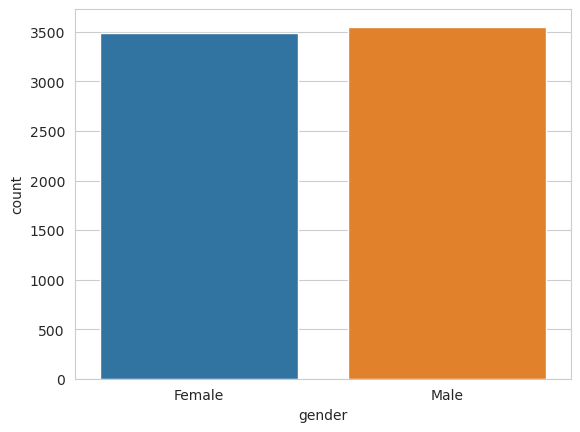

In [23]:
sns.set_style('whitegrid')
sns.countplot(x='gender',data=df)

<Axes: xlabel='InternetService', ylabel='count'>

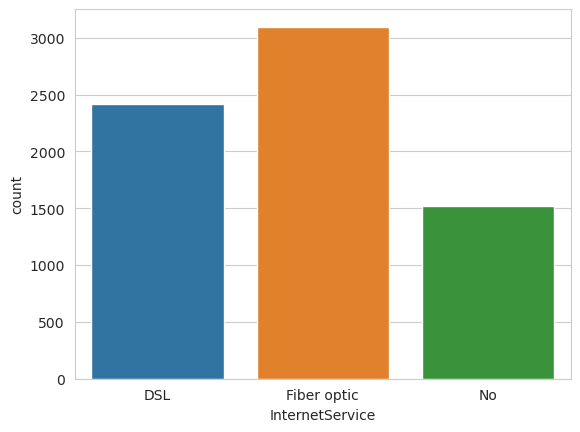

In [24]:
sns.set_style('whitegrid')
sns.countplot(x='InternetService',data=df)

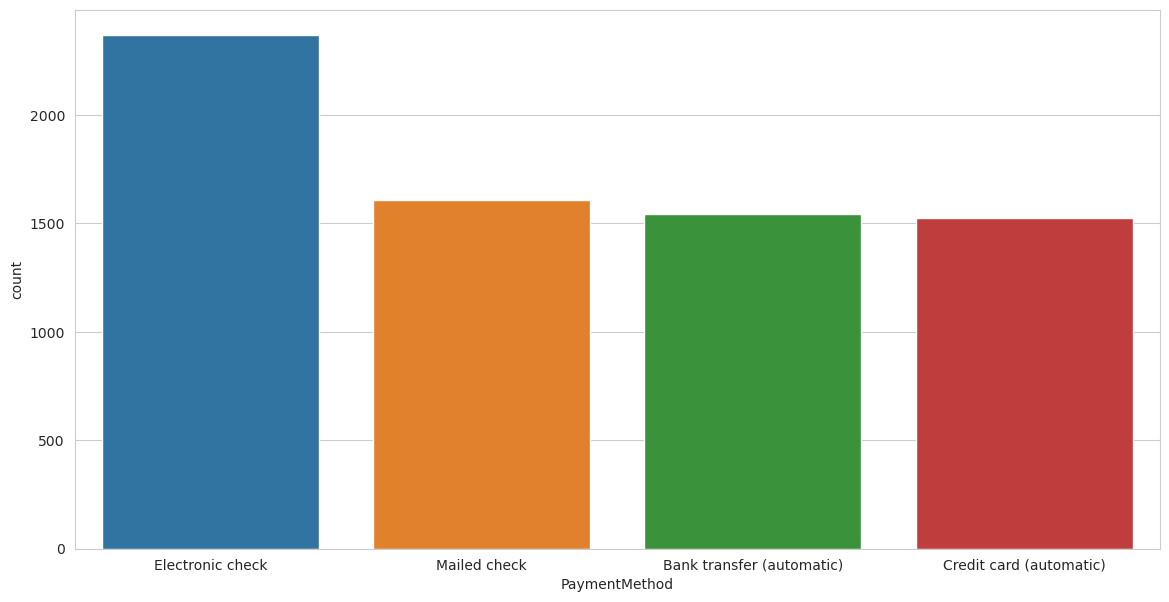

In [25]:
plt.figure(figsize=(14,7))
sns.set_style('whitegrid')
sns.countplot(x='PaymentMethod',data=df)
plt.show()

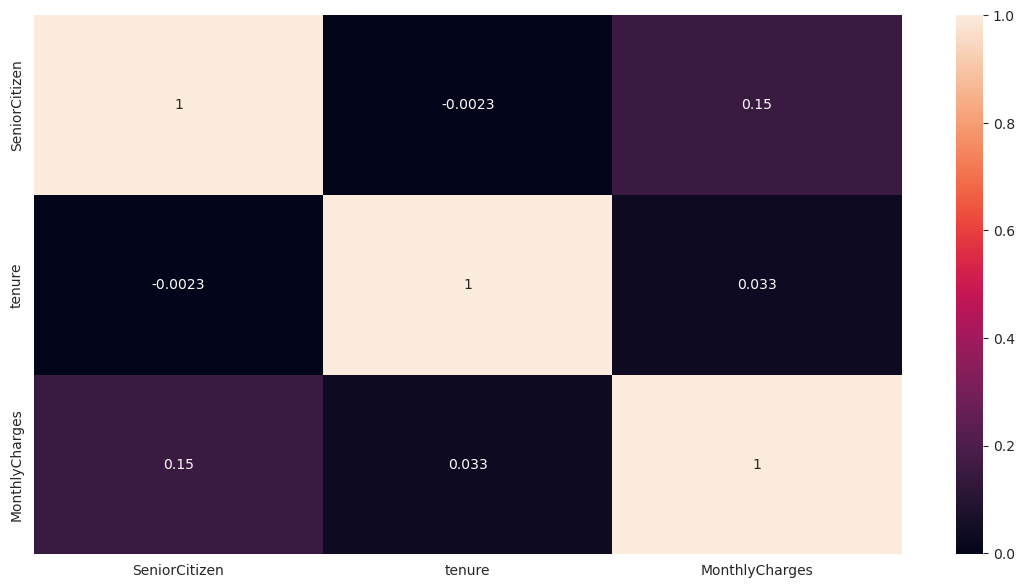

In [26]:
plt.figure(figsize=(14,7))
cor = df.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [27]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

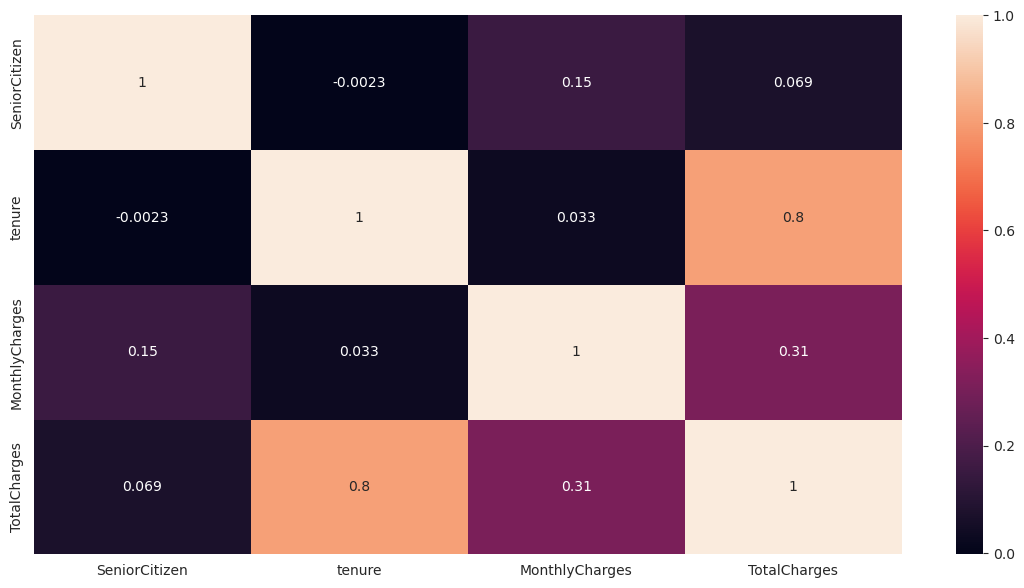

In [28]:
plt.figure(figsize=(14,7))
cor = df.corr()
sns.heatmap(cor, annot=True)
plt.show()

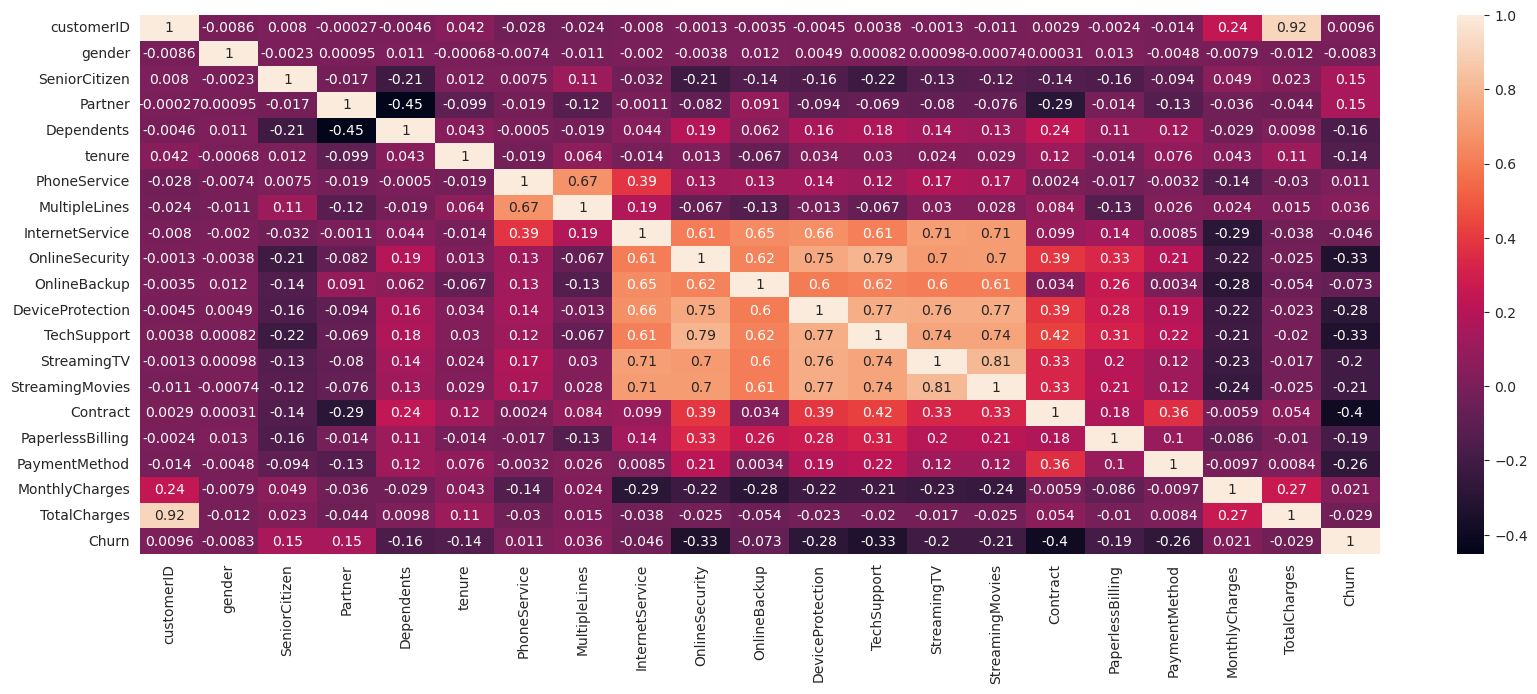

In [26]:
corrDF = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corrDF
plt.figure(figsize=(20,7))
sns.heatmap(corrDF, annot=True)
plt.show()

<Axes: xlabel='Churn', ylabel='count'>

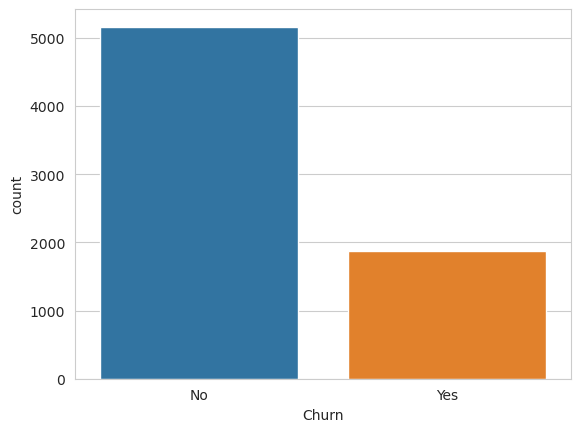

In [29]:
sns.set_style('whitegrid')
sns.countplot(x='Churn',data=df)

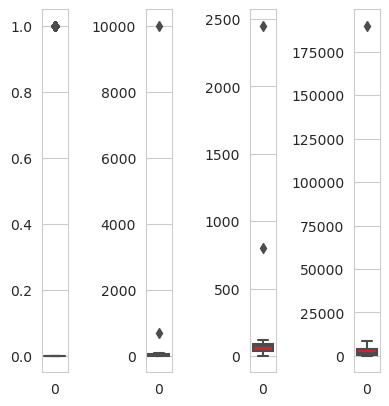

In [30]:
## Outliers
import numpy as np
numericDF = df[['SeniorCitizen', 'tenure','MonthlyCharges','TotalCharges']].copy()
l = numericDF.columns.values
number_of_columns=4
number_of_rows = int(np.round(len(l)-1/number_of_columns))
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows+1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data=numericDF[l[i]],color="red",orient="v")
    plt.tight_layout()

In [31]:
newdata.groupBy("SeniorCitizen").count().show()

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|            1| 1143|
|            0| 5894|
+-------------+-----+



<Axes: xlabel='SeniorCitizen', ylabel='count'>

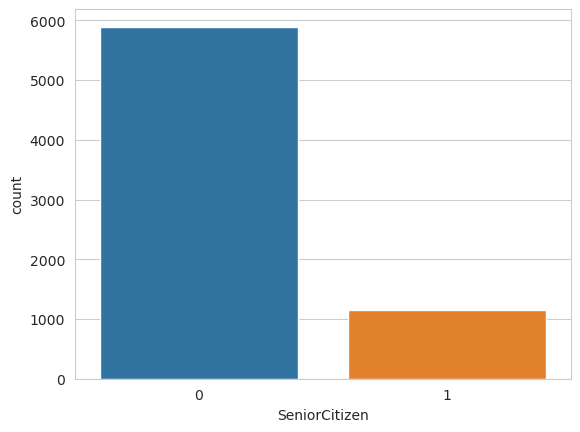

In [32]:
sns.set_style('whitegrid')
sns.countplot(x='SeniorCitizen',data=df)

In [33]:
newdata = newdata.where(newdata.MonthlyCharges < 500)

In [34]:
newdata = newdata.where(newdata.TotalCharges < 25000)

In [35]:
newdata = newdata.where(newdata.tenure < 200)

In [31]:
#newdata.select(col("TotalCharges").cast('float').alias("TotalCharges"))

In [36]:
newdata2 = newdata.withColumn("TotalChargesFloat", col("TotalCharges").cast("float"))

# show the updated DataFrame
newdata2.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-----------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|TotalChargesFloat|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-----------------+
|7590-V

In [37]:
newdata_final = newdata2.withColumn("Churn", when(col("Churn") == "Yes", 1).otherwise(0))

In [38]:
## Analyse visuelle
df = newdata_final.toPandas()
df.head(100)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalChargesFloat
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,29.850000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0,1889.500000
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,108.150002
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1840.750000
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,151.649994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8637-XJIVR,Female,0,No,No,12,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,78.95,927.35,1,927.349976
96,9803-FTJCG,Male,0,Yes,Yes,71,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Credit card (automatic),66.85,4748.7,0,4748.700195
97,0278-YXOOG,Male,0,No,No,5,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,21.05,113.85,1,113.849998
98,3212-KXOCR,Male,0,No,No,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),21.00,1107.2,0,1107.199951


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7034 entries, 0 to 7033
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7034 non-null   object 
 1   gender             7034 non-null   object 
 2   SeniorCitizen      7034 non-null   int32  
 3   Partner            7034 non-null   object 
 4   Dependents         7034 non-null   object 
 5   tenure             7034 non-null   int32  
 6   PhoneService       7034 non-null   object 
 7   MultipleLines      7034 non-null   object 
 8   InternetService    7034 non-null   object 
 9   OnlineSecurity     7034 non-null   object 
 10  OnlineBackup       7034 non-null   object 
 11  DeviceProtection   7034 non-null   object 
 12  TechSupport        7034 non-null   object 
 13  StreamingTV        7034 non-null   object 
 14  StreamingMovies    7034 non-null   object 
 15  Contract           7034 non-null   object 
 16  PaperlessBilling   7034 

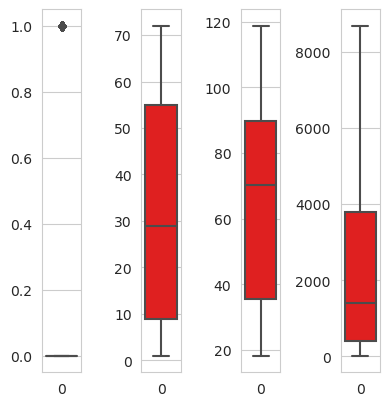

In [40]:
## Outliers
import numpy as np
numericDF = df[['SeniorCitizen', 'tenure','MonthlyCharges','TotalChargesFloat']].copy()
l = numericDF.columns.values
number_of_columns=4
number_of_rows = int(np.round(len(l)-1/number_of_columns))
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows+1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data=numericDF[l[i]],color="red",orient="v")
    plt.tight_layout()

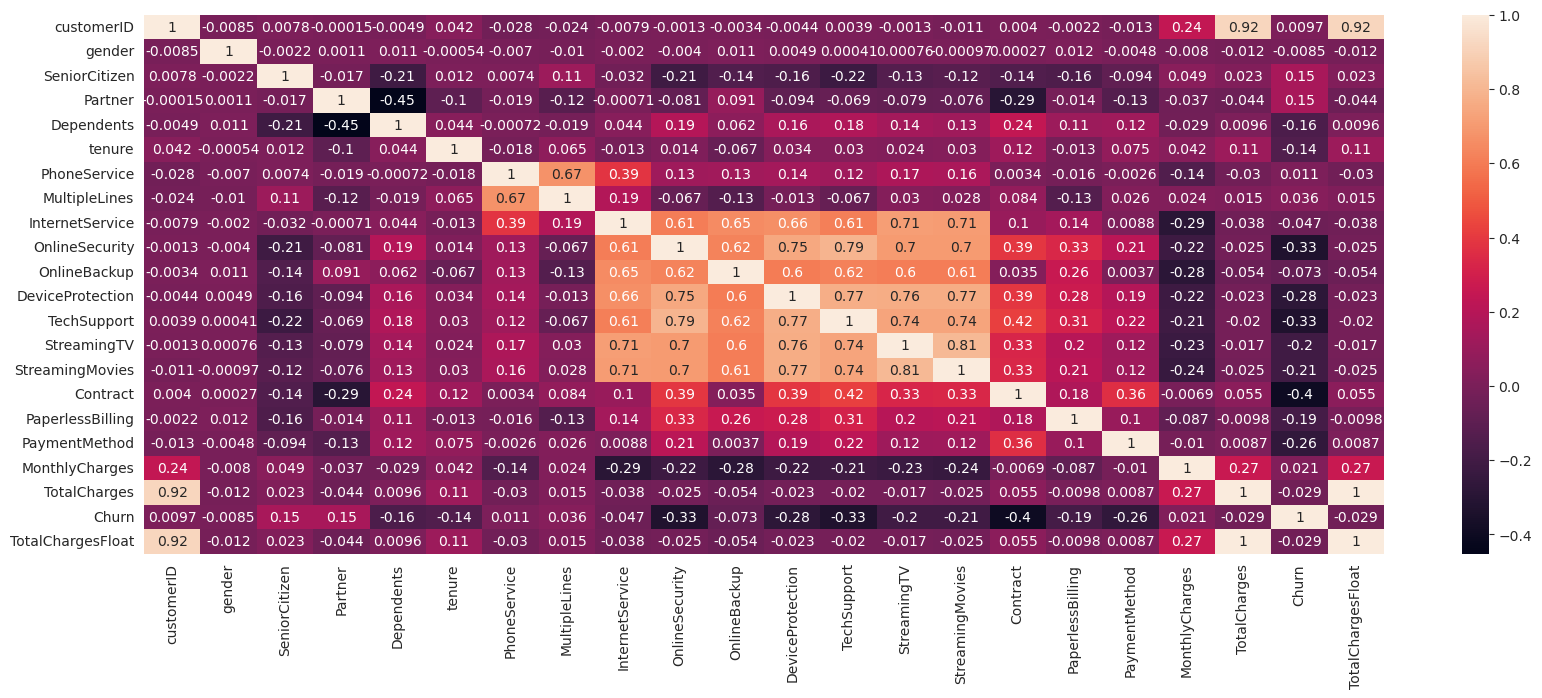

In [41]:
corrDF = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corrDF
plt.figure(figsize=(20,7))
sns.heatmap(corrDF, annot=True)
plt.show()

In [42]:
genderIndexer = StringIndexer(inputCol="gender", outputCol="gender_Num")
genderEncoder = OneHotEncoder(inputCols=["gender_Num"], outputCols=["gender_Vector"])

In [43]:
partnerIndexer = StringIndexer(inputCol="Partner", outputCol="partner_Num")
partnerEncoder = OneHotEncoder(inputCols=["partner_Num"], outputCols=["partner_Vector"])

In [44]:
dependentsIndexer = StringIndexer(inputCol="Dependents", outputCol="dependents_Num")
dependentsEncoder = OneHotEncoder(inputCols=["dependents_Num"], outputCols=["dependents_Vector"])

In [45]:
phoneIndexer = StringIndexer(inputCol="PhoneService", outputCol="phone_Num")
phoneEncoder = OneHotEncoder(inputCols=["phone_Num"], outputCols=["phone_Vector"])

In [46]:
lineIndexer = StringIndexer(inputCol="MultipleLines", outputCol="line_Num")
lineEncoder = OneHotEncoder(inputCols=["line_Num"], outputCols=["line_Vector"])

In [47]:
netIndexer = StringIndexer(inputCol="InternetService", outputCol="net_Num")
netEncoder = OneHotEncoder(inputCols=["net_Num"], outputCols=["net_Vector"])

In [48]:
secIndexer = StringIndexer(inputCol="OnlineSecurity", outputCol="sec_Num")
secEncoder = OneHotEncoder(inputCols=["sec_Num"], outputCols=["sec_Vector"])

In [49]:
backIndexer = StringIndexer(inputCol="OnlineBackup", outputCol="back_Num")
backEncoder = OneHotEncoder(inputCols=["back_Num"], outputCols=["back_Vector"])

In [50]:
protectionIndexer = StringIndexer(inputCol="DeviceProtection", outputCol="protection_Num")
protectionEncoder = OneHotEncoder(inputCols=["protection_Num"], outputCols=["protection_Vector"])

In [51]:
techIndexer = StringIndexer(inputCol="TechSupport", outputCol="tech_Num")
techEncoder = OneHotEncoder(inputCols=["tech_Num"], outputCols=["tech_Vector"])

In [52]:
tvIndexer = StringIndexer(inputCol="StreamingTV", outputCol="tv_Num")
tvEncoder = OneHotEncoder(inputCols=["tv_Num"], outputCols=["tv_Vector"])

In [53]:
movIndexer = StringIndexer(inputCol="StreamingMovies", outputCol="mov_Num")
movEncoder = OneHotEncoder(inputCols=["mov_Num"], outputCols=["mov_Vector"])

In [54]:
contIndexer = StringIndexer(inputCol="Contract", outputCol="cont_Num")
contEncoder = OneHotEncoder(inputCols=["cont_Num"], outputCols=["cont_Vector"])

In [55]:
paperIndexer = StringIndexer(inputCol="PaperlessBilling", outputCol="paper_Num")
paperEncoder = OneHotEncoder(inputCols=["paper_Num"], outputCols=["paper_Vector"])

In [56]:
payIndexer = StringIndexer(inputCol="PaymentMethod", outputCol="pay_Num")
payEncoder = OneHotEncoder(inputCols=["pay_Num"], outputCols=["pay_Vector"])

In [57]:
#--------------------------------------------------------------
# Etape 5: assembler
#--------------------------------------------------------------
dfAssembler = VectorAssembler(inputCols=["gender_Vector", 
                                         "SeniorCitizen", 
                                         "partner_Vector",
                                         "dependents_Vector",
                                         "phone_Vector",
                                         "line_Vector",
                                         "net_Vector",
                                         "sec_Vector",
                                         "back_Vector",
                                         "protection_Vector",
                                         "tech_Vector",
                                         "tv_Vector",
                                         "mov_Vector",
                                         "cont_Vector",
                                         "paper_Vector",
                                         "pay_Vector",
                                         "tenure",
                                         "MonthlyCharges",
                                         "TotalChargesFloat"] , outputCol="features")

In [58]:
logreg = LogisticRegression(labelCol="Churn")

In [59]:
# Pipeline
pipeline = Pipeline(stages=[genderIndexer,
                            genderEncoder,
                            partnerIndexer,
                            partnerEncoder,
                            dependentsIndexer,
                            dependentsEncoder,
                            phoneIndexer,
                            phoneEncoder,
                            lineIndexer,
                            lineEncoder,
                            netIndexer,
                            netEncoder,
                            secIndexer,
                            secEncoder,
                            backIndexer,
                            backEncoder,
                            protectionIndexer,
                            protectionEncoder,
                            techIndexer,
                            techEncoder,
                            tvIndexer,
                            tvEncoder,
                            movIndexer,
                            movEncoder,
                            contIndexer,
                            contEncoder,
                            paperIndexer,
                            paperEncoder,
                            payIndexer,
                            payEncoder,
                            dfAssembler,
                            logreg])

In [61]:
#--------------------------------------------------------------
# Split the data
#--------------------------------------------------------------
trainDf, testDf = newdata_final.randomSplit([0.75, 0.25])

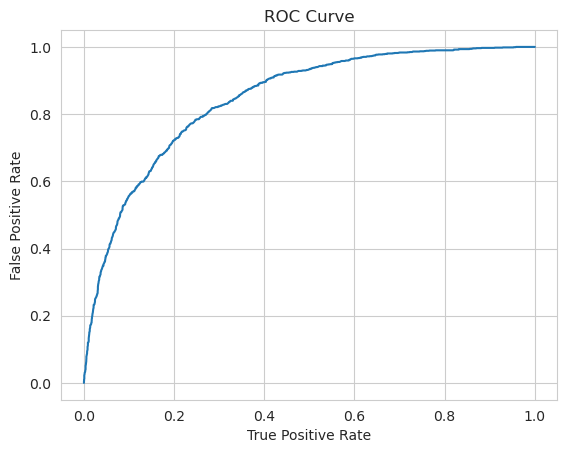

Training set areaUnderROC: 0.8456002561231771


In [63]:
# Results
model = pipeline.fit(trainDf)

trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [62]:
model = pipeline.fit(trainDf)
lrModel = model.stages[-1]

results = model.transform(testDf)

coefficients = lrModel.coefficients.toArray().tolist()

# Loop through the features to extract the original column names
features = dict()
for variable_type in ['numeric', 'binary']:
    for variable in results.schema["features"].metadata["ml_attr"]["attrs"][variable_type]:
        features[variable['idx']] = variable['name']

# Loop through all of the variables found and print out the associated coefficients
for i in range(len(features)):
    print(i, features[i], coefficients[i])

0 gender_Vector_Male -0.026435994092298302
1 SeniorCitizen 0.22920729753928584
2 partner_Vector_No -0.04643564517958906
3 dependents_Vector_No 0.18156689184976146
4 phone_Vector_Yes -6.221900889645435
5 line_Vector_No 6.376253679102319
6 line_Vector_Yes 6.819652507640826
7 net_Vector_Fiber optic 1.0600078345196238
8 net_Vector_DSL -0.3701081801198996
9 sec_Vector_No 0.5583313810261025
10 sec_Vector_Yes 0.18696877006206916
11 back_Vector_No 0.38146862204693355
12 back_Vector_Yes 0.37416712567388
13 protection_Vector_No 0.2834172047547361
14 protection_Vector_Yes 0.4785195682141696
15 tech_Vector_No 0.4820718412366944
16 tech_Vector_Yes 0.27781150424877227
17 tv_Vector_No 0.11726724717178116
18 tv_Vector_Yes 0.6364356887046351
19 mov_Vector_No 0.11857366943567321
20 mov_Vector_Yes 0.6304847549786509
21 cont_Vector_Month-to-month 0.5955490293992816
22 cont_Vector_Two year -0.6111641953311435
23 paper_Vector_Yes 0.30109411178959816
24 pay_Vector_Electronic check 0.3771962469067024
25 pay_V

In [66]:
# The coefficients which can give the best split of the data in a segnificant order:
# line_Vector
# back_Vector
# protection_Vector
# tech_Vector
# tv_Vector
# mov_Vector

# We try to add one by one to see how the ROC on the training data differe starting only with line_Vector

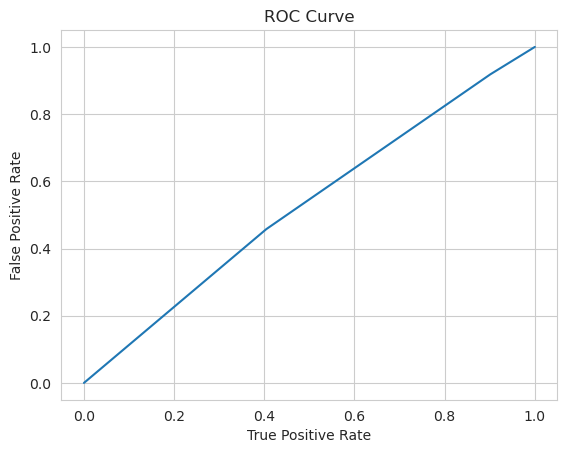

Training set areaUnderROC: 0.5291139087356431


In [67]:
# Forward Algorithm (Step 1):

dfAssembler = VectorAssembler(inputCols=["line_Vector"] , outputCol="features")
logreg = LogisticRegression(labelCol="Churn")
pipeline = Pipeline(stages=[lineIndexer,
                            lineEncoder,
                            dfAssembler,
                            logreg])                           

model_forward1 = pipeline.fit(trainDf)

trainingSummary = model_forward1.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

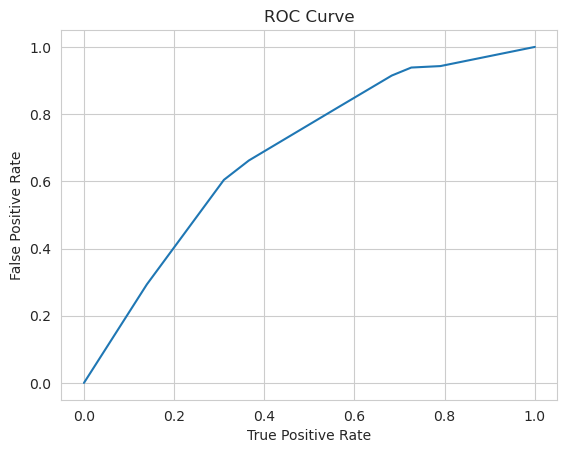

Training set areaUnderROC: 0.6864769382112141


In [68]:
# Forward Algorithm (Step 2):

dfAssembler = VectorAssembler(inputCols=["line_Vector",
                                         "back_Vector"] , outputCol="features")
logreg = LogisticRegression(labelCol="Churn")
pipeline = Pipeline(stages=[lineIndexer,
                            lineEncoder,
                            backIndexer,
                            backEncoder,
                            dfAssembler,
                            logreg])                           

model_forward2 = pipeline.fit(trainDf)

trainingSummary = model_forward2.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

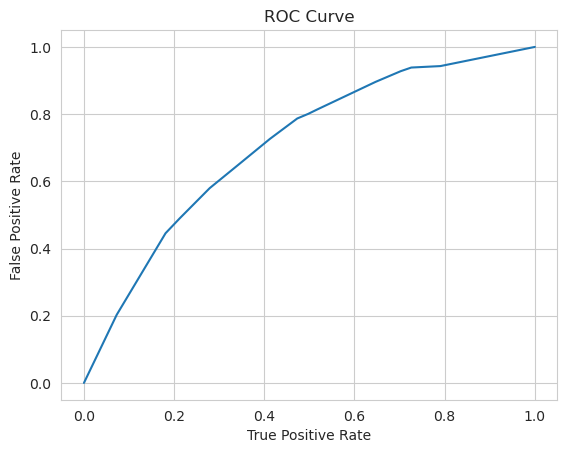

Training set areaUnderROC: 0.7088334575791334


In [69]:
# Forward Algorithm (Step 3):

dfAssembler = VectorAssembler(inputCols=["line_Vector",
                                         "back_Vector",
                                         "protection_Vector"] , outputCol="features")
logreg = LogisticRegression(labelCol="Churn")
pipeline = Pipeline(stages=[lineIndexer,
                            lineEncoder,
                            backIndexer,
                            backEncoder,
                            protectionIndexer,
                            protectionEncoder,
                            dfAssembler,
                            logreg])                           

model_forward3 = pipeline.fit(trainDf)

trainingSummary = model_forward3.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

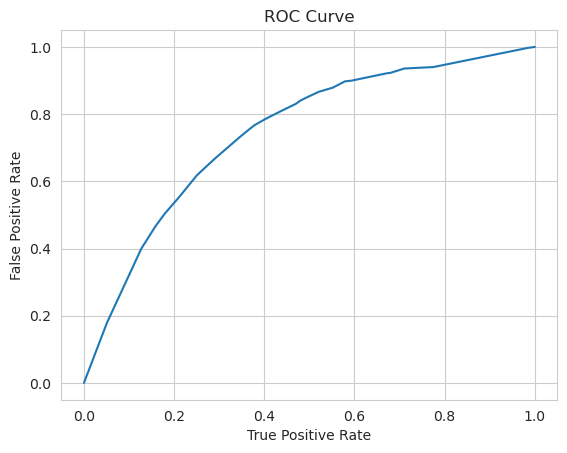

Training set areaUnderROC: 0.7457704775226782


In [70]:
# Forward Algorithm (Step 4):

dfAssembler = VectorAssembler(inputCols=["line_Vector",
                                         "back_Vector",
                                         "protection_Vector",
                                         "tech_Vector"] , outputCol="features")
logreg = LogisticRegression(labelCol="Churn")
pipeline = Pipeline(stages=[lineIndexer,
                            lineEncoder,
                            backIndexer,
                            backEncoder,
                            protectionIndexer,
                            protectionEncoder,
                            techIndexer,
                            techEncoder,
                            dfAssembler,
                            logreg])                           

model_forward4 = pipeline.fit(trainDf)

trainingSummary = model_forward4.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

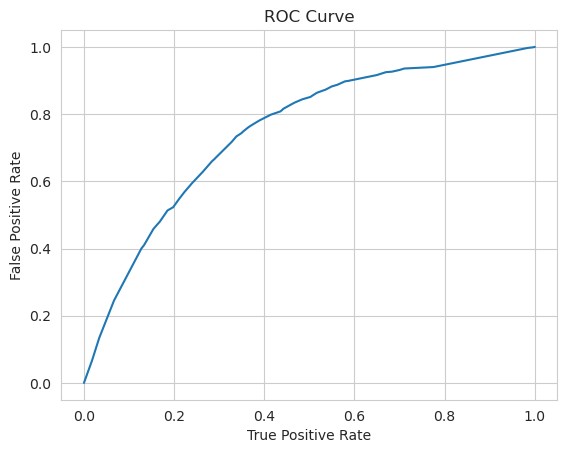

Training set areaUnderROC: 0.7476392832646025


In [71]:
# Forward Algorithm (Step 5):

dfAssembler = VectorAssembler(inputCols=["line_Vector",
                                         "back_Vector",
                                         "protection_Vector",
                                         "tech_Vector",
                                         "tv_Vector"] , outputCol="features")
logreg = LogisticRegression(labelCol="Churn")
pipeline = Pipeline(stages=[lineIndexer,
                            lineEncoder,
                            backIndexer,
                            backEncoder,
                            protectionIndexer,
                            protectionEncoder,
                            techIndexer,
                            techEncoder,
                            tvIndexer,
                            tvEncoder,
                            dfAssembler,
                            logreg])                           

model_forward5 = pipeline.fit(trainDf)

trainingSummary = model_forward5.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

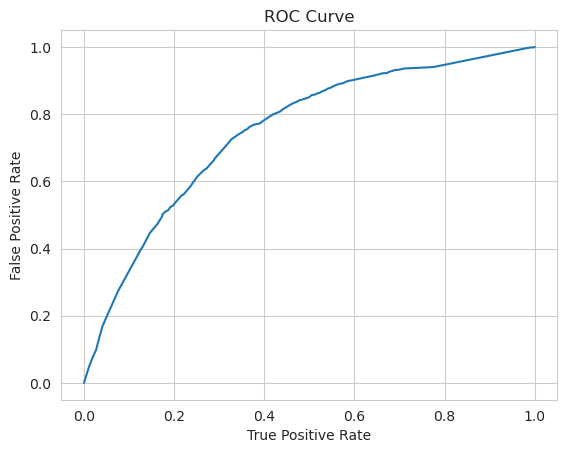

Training set areaUnderROC: 0.7481457594024289


In [72]:
# Forward Algorithm (Step 6):

dfAssembler = VectorAssembler(inputCols=["line_Vector",
                                         "back_Vector",
                                         "protection_Vector",
                                         "tech_Vector",
                                         "tv_Vector",
                                         "mov_Vector"] , outputCol="features")
logreg = LogisticRegression(labelCol="Churn")
pipeline = Pipeline(stages=[lineIndexer,
                            lineEncoder,
                            backIndexer,
                            backEncoder,
                            protectionIndexer,
                            protectionEncoder,
                            techIndexer,
                            techEncoder,
                            tvIndexer,
                            tvEncoder,
                            movIndexer,
                            movEncoder,
                            dfAssembler,
                            logreg])                           

model_forward6 = pipeline.fit(trainDf)

trainingSummary = model_forward6.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

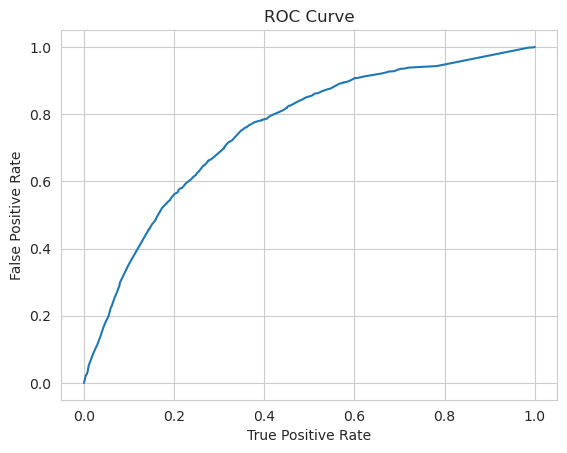

Training set areaUnderROC: 0.7530014900189207


In [73]:
# Forward Algorithm (Step 7):

dfAssembler = VectorAssembler(inputCols=["SeniorCitizen",
                                         "line_Vector",
                                         "back_Vector",
                                         "protection_Vector",
                                         "tech_Vector",
                                         "tv_Vector",
                                         "mov_Vector"] , outputCol="features")
logreg = LogisticRegression(labelCol="Churn")
pipeline = Pipeline(stages=[lineIndexer,
                            lineEncoder,
                            backIndexer,
                            backEncoder,
                            protectionIndexer,
                            protectionEncoder,
                            techIndexer,
                            techEncoder,
                            tvIndexer,
                            tvEncoder,
                            movIndexer,
                            movEncoder,
                            dfAssembler,
                            logreg])                           

model_forward7 = pipeline.fit(trainDf)

trainingSummary = model_forward7.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

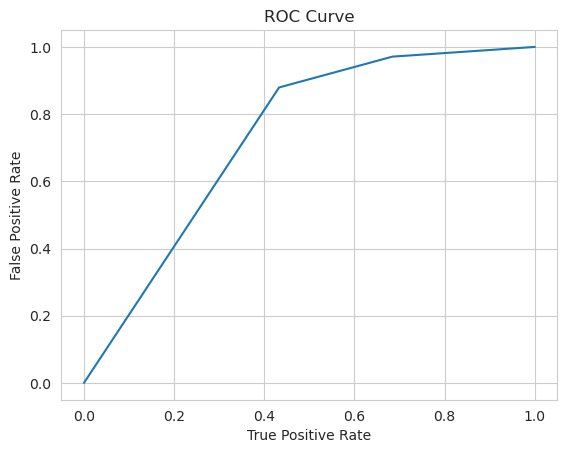

Training set areaUnderROC: 0.7341388370034705


In [74]:
# Forward Algorithm (Step test):

dfAssembler = VectorAssembler(inputCols=["cont_Vector"] , outputCol="features")
logreg = LogisticRegression(labelCol="Churn")
pipeline = Pipeline(stages=[contIndexer,
                            contEncoder,
                            dfAssembler,
                            logreg])                           

model_forwardtest = pipeline.fit(trainDf)

trainingSummary = model_forwardtest.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [75]:
# The step before shows that the coef. should not be considered according to their 
# values (larger they are, best split they give) 
# because 
# line_Vector_No 6.376253679102319
# line_Vector_Yes 6.819652507640826
# give lower traning accuarcy than 
# cont_Vector_Month-to-month 0.5955490293992816
# cont_Vector_Two year -0.6111641953311435

# In the Pipline_log_Altakroury, a random forward algorithm is considered:
# first the one-column-model is tested considering all the variables (columns)
# then one column is added each time according to the resulted accuracy.

# Below, I continue the analysis when considering all the variables for logistic regression.

In [76]:
dfAssembler = VectorAssembler(inputCols=["gender_Vector", 
                                         "SeniorCitizen", 
                                         "partner_Vector",
                                         "dependents_Vector",
                                         "phone_Vector",
                                         "line_Vector",
                                         "net_Vector",
                                         "sec_Vector",
                                         "back_Vector",
                                         "protection_Vector",
                                         "tech_Vector",
                                         "tv_Vector",
                                         "mov_Vector",
                                         "cont_Vector",
                                         "paper_Vector",
                                         "pay_Vector",
                                         "tenure",
                                         "MonthlyCharges",
                                         "TotalChargesFloat"] , outputCol="features")

logreg = LogisticRegression(labelCol="Churn")

pipeline = Pipeline(stages=[genderIndexer,
                            genderEncoder,
                            partnerIndexer,
                            partnerEncoder,
                            dependentsIndexer,
                            dependentsEncoder,
                            phoneIndexer,
                            phoneEncoder,
                            lineIndexer,
                            lineEncoder,
                            netIndexer,
                            netEncoder,
                            secIndexer,
                            secEncoder,
                            backIndexer,
                            backEncoder,
                            protectionIndexer,
                            protectionEncoder,
                            techIndexer,
                            techEncoder,
                            tvIndexer,
                            tvEncoder,
                            movIndexer,
                            movEncoder,
                            contIndexer,
                            contEncoder,
                            paperIndexer,
                            paperEncoder,
                            payIndexer,
                            payEncoder,
                            dfAssembler,
                            logreg])

trainDf, testDf = newdata_final.randomSplit([0.75, 0.25])

results = model.transform(testDf)

results.select("Churn","prediction","rawPrediction","probability").show(40, truncate=False)

predictionAndLabels= results.rdd.map(lambda row: (float(row.Churn), row.prediction))

# Récupération des métriques
metrics = MulticlassMetrics(predictionAndLabels)

# Matrice de confusion
print("Confusion matrix: %s" % metrics.confusionMatrix().toArray())
print("True negative: %s" % metrics.confusionMatrix().toArray()[0,0])
print("False positive: %s" % metrics.confusionMatrix().toArray()[0,1])
print("False negative: %s" % metrics.confusionMatrix().toArray()[1,0])
print("True positive: %s" % metrics.confusionMatrix().toArray()[1,1])
print("Accuracy = %s" % metrics.accuracy)

+-----+----------+--------------------------------------------+-----------------------------------------+
|Churn|prediction|rawPrediction                               |probability                              |
+-----+----------+--------------------------------------------+-----------------------------------------+
|1    |1.0       |[-1.0611856146101653,1.0611856146101653]    |[0.2570829474061015,0.7429170525938985]  |
|0    |0.0       |[2.960438652963518,-2.960438652963518]      |[0.9507545358618749,0.04924546413812514] |
|0    |0.0       |[0.4086493223373653,-0.4086493223373653]    |[0.6007639675058851,0.3992360324941149]  |
|0    |1.0       |[-0.7123162141350499,0.7123162141350499]    |[0.3290872436855858,0.6709127563144142]  |
|0    |0.0       |[4.718752394492828,-4.718752394492828]      |[0.9911526659145428,0.008847334085457237]|
|1    |1.0       |[-0.7081413417338223,0.7081413417338223]    |[0.3300096657215874,0.6699903342784126]  |
|1    |1.0       |[-0.5978596986556941,0.59785

In [77]:
#--------------------------------------------------------------
# BinaryClassificationEvaluator
#--------------------------------------------------------------
evaluator = BinaryClassificationEvaluator(labelCol="Churn",rawPredictionCol="rawPrediction", metricName="areaUnderPR")
						
print("Model accuracy : %s " % evaluator.evaluate(results))

Model accuracy : 0.6656345505278879 


In [78]:
#--------------------------------------------------------------
# Cross validation
#--------------------------------------------------------------
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, numFolds=5, collectSubModels=True)
					
params = ParamGridBuilder().addGrid(logreg.maxIter,[1000]).addGrid(logreg.regParam, [ 0.5, 0.05, 0.1,]).build()
						
cv.setEstimatorParamMaps(params)
cvmodel = cv.fit(trainDf)

bestModel = cvmodel.bestModel
print("Coefficients: \n %s" % bestModel.stages[-1].coefficients)
print("Best regParam: %s" % bestModel.stages[-1].getRegParam())
bestModel.stages[-1].extractParamMap()

Coefficients: 
 [-0.02941513444895209,0.18853837701862933,0.08361068501914824,0.09610728620383321,-0.20345548026602556,-0.0929706758918561,0.028199067125874153,0.43277830628505276,-0.2674476203778803,0.30416589319033077,-0.15004531840880625,0.1862191840779589,-0.002759065876753493,0.15625306608476683,0.02974148902169121,0.25909438261872486,-0.09403120798336811,0.026207574949703997,0.16531232043079633,0.013819738389405038,0.1778378609362058,0.5575914882379742,-0.4570484577925249,0.28356158215920446,0.34961575763303004,-0.009210679802811853,-0.20270156322026106,-0.01604971221325944,0.0043477027557808495,-7.026150536885384e-05]
Best regParam: 0.05


{Param(parent='LogisticRegression_a164c9590f44', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_a164c9590f44', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_a164c9590f44', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_a164c9590f44', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_a164c9590f44', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_a164c9590f44', name='labelCol', doc='label column name.'): 'Churn',
 Param(parent='LogisticRegression_a164c9590f44', name='maxBlockSizeInMB', doc='maximum memory in MB for s